In [1]:
import sys
sys.path.append('../../Libretas Jupyter')
from rnautils import rnautils as Utils
from rnautils import rfam as Rfam
from rnautils import cdhit as Cdhit
from rnautils import blast as Blast
from features.seq_composition import SeqComposition
import features.arffutils as Arffutils
import features.wekautils as Wekautils

In [2]:
import sys
import os
from os import listdir,path
import shutil
import gzip
import csv
import textwrap
import re 
from collections import Counter
import pandas as pd
from pandas import DataFrame
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg

rfam11_path = r'/home/hugo/Documents/DATABASES/RFAM/11.0'
basepath = r'/home/hugo/Documents/PUBLICATIONS/2017-Riboswitches-split'
blast_path = r'/home/hugo/Documents/APPS/ncbi-blast-2.6.0+/bin'
weka_output = r'/home/hugo/Dropbox/DOCTORADO CICESE/000 TESIS/Software/Libretas Jupyter/riboswitches2/weka/60-40'
manuscript_path = r'/home/hugo/Dropbox/zzzSubmissions/+Por escribir/2017-1 Riboswitch classification/biosystems'

## Prebuild
Execute this cell to generate the initial folder structure and files.

In [3]:
blast_output_path = path.join(basepath,'blastn')
docs_path = path.join(basepath,'docs')
raw_path = path.join(basepath,'raw')
features_path = path.join(basepath,'features')
results_path = path.join(basepath,'results')
results_raw_path = path.join(basepath,'results_raw')
results_parsed_path = path.join(basepath,'results_parsed')

for f in [basepath,blast_path,docs_path,raw_path,features_path,
          results_path,results_raw_path,results_parsed_path]:
    if not path.exists(f):
        os.makedirs(f)

fasta_transform = lambda x:x.upper().replace('T','U')
id_transform=lambda x:x.split('|')[0].replace(' ','_')
float_format='%.3f'
img_format = 'png'

#Write families list
families = ['RF00174','RF01051','RF00050','RF00234','RF00504','RF00168','RF00522','RF01054',
            'RF00167','RF00162','RF00521','RF00634','RF01057','RF00059','RF00380','RF01055']
families = sorted(families)
families_file = path.join(basepath,'docs','families.txt')
with open(families_file,'w') as f:
    f.write('\n'.join(families))
print('Wrote',families_file,file=sys.stderr)
results_singh = {'ACC':.81, #Fig. 4
         'Sen':.9142,
         'Spe':.2609,
         'F1':.3305}

#File locations
rfam11_seqs_raw_csv = path.join(raw_path,'rfam11_raw.csv')
rfam11_seqs_raw = path.join(raw_path,'rfam11_raw.fasta')
rfam11_seqs_nr = path.join(raw_path,'rfam11_nr.fasta')
training_seqs = path.join(raw_path,'training.fasta')
test_seqs = path.join(raw_path,'test.fasta')
test_hard_seqs = path.join(raw_path,'test_hard.fasta')
seqs_summary = path.join(docs_path,'summary.csv')

#Features
features_training = path.join(features_path,'training-hex.arff')
features_test = path.join(features_path,'test-hex.arff')
features_test_hard = path.join(features_path,'test-hard-hex.arff')
features_training_dnc = path.join(features_path,'training-dnc.arff')
features_test_dnc = path.join(features_path,'test-dnc.arff')
features_test_hard_dnc = path.join(features_path,'test-hard-dnc.arff')

#Feature selection
cfs_training = path.join(features_path,'training-hex-cfs.arff')
cfs_test = path.join(features_path,'test-hex-cfs.arff')
cfs_test_hard = path.join(features_path,'test-hard-hex-cfs.arff')

Wrote /home/hugo/Documents/PUBLICATIONS/2017-Riboswitches-split/docs/families.txt


# Methods

In [4]:
def fastacsv_to_fasta(input_csv,output_fasta,fasta_transform=lambda x:x):
    o_f = open(output_fasta,'w')
    with open(input_csv) as f:
        f.readline()
        for line in f:
            line=line.strip()
            if len(line)==0:
                continue
            fields = line.split(',')
            o_f.write(Utils.fasta_string(fields[1] + '|' + fields[0],fields[2],
                                        fasta_transform=fasta_transform))
    o_f.close()
    print('Wrote',output_fasta,file=sys.stderr)
    
    
def retrieve_from_fasta(input_fasta,id_list,output_fasta):
    ids = {i:'' for i in id_list}
    with open(output_fasta,'w') as f:
        for r in Utils.parse_fasta(input_fasta):
            if r['id'] in ids:
                f.write(Utils.fasta_string(r['id'],r['sequence']))
    print('Wrote',output_fasta,file=sys.stderr)
    
    
def summary_fasta_seqs(fasta_list,output_csv):
    labels = {}
    for r in Utils.parse_fasta(fasta_list[0],id_transform=lambda x:x.split('|')[0]):        
        labels[r['id']]=''
    labels = sorted(labels.keys())
    data = {}
    order = []
    for f in fasta_list:
        counter = {l:0 for l in labels}
        name = path.basename(f).replace('.fasta','')
        order.append(name)
        for r in Utils.parse_fasta(f,id_transform=lambda x:x.split('|')[0]):
            counter[r['id']]+=1
        data[name] = counter
    df = DataFrame.from_dict(data,orient='index')
    df['TOTAL'] = df.sum(axis=1)    
    df = df.T
    df = df[order]
    df.to_csv(output_csv)
    print('Wrote',output_csv,file=sys.stderr)
    
    
def merge_weka_results(input_files,output_file):
    df = DataFrame()
    for i in input_files:
        if df.empty:
            df = pd.read_csv(i,index_col=0)
        else:
            df = pd.concat([df,pd.read_csv(i,index_col=0)])
    df.to_csv(output_file, float_format=float_format)
    
    
def extract_weka_results(knowledgeflow_obj,output_path,prefix,title=''):
    r = knowledgeflow_obj
    _scheme = r['Scheme']
    _confusion_csv = path.join(output_path,prefix+_scheme+'-confusion.csv')
    _confusion_img = path.join(output_path,prefix+_scheme+'-confusion.'+img_format)
    _metrics_csv = path.join(output_path,prefix+_scheme+'-weka_metrics.csv')    
    r['confusion'].to_csv(_confusion_csv)
    r['metrics'].to_csv(_metrics_csv, float_format=float_format)
    Wekautils.plot_confusion_from_pandas(r['confusion'],title=prefix+_scheme,output=_confusion_img)    
    
    
def get_metrics_from_confusion(confusion_matrix,labels):    
    order = ['support','sup_frac','TP','TN','FP','FN','Sen','Spe','F1','MCC','PPV','NPV','FPR','FNR','FDR']
    n = confusion_matrix.sum(axis=None)
    FP = confusion_matrix.sum(axis=0) - np.diag(confusion_matrix)  
    FN = confusion_matrix.sum(axis=1) - np.diag(confusion_matrix)
    TP = np.diag(confusion_matrix)    
    TN = n - (FP + FN + TP)
    d = {'class':labels,
        'support' : confusion_matrix.sum(axis=1),
        'sup_frac' :  confusion_matrix.sum(axis=1)/n,
        'FP':FP,'FN':FN,'TP':TP,'TN':TN,        
        'Sen' : TP/(TP+FN),# Sensitivity, hit rate, recall, or true positive rate        
        'Spe' : TN/(TN+FP),# Specificity or true negative rate        
        'F1' : 2*TP/(2*TP+FP+FN),# F-measure        
        'MCC' : (TP*TN - FP*FN)/(np.sqrt((TP+FP)*(TP+FN)*(TN+FP)*(TN+FN))),        
        'PPV' : TP/(TP+FP),# Precision or positive predictive value        
        'NPV' : TN/(TN+FN),# Negative predictive value        
        'FPR' : FP/(FP+TN),# Fall out or false positive rate        
        'FNR' : FN/(TP+FN),# False negative rate        
        'FDR' : FP/(TP+FP)# False discovery rate
        }         
    df_byclass = DataFrame.from_dict(d).set_index(['class']).fillna(0)
    df_byclass = df_byclass[order]
    df = df_byclass.copy()
    to_weight = ['Sen','Spe','F1','MCC']
    for c in to_weight:
        df['w_'+c] = df[c]*df['sup_frac']
    D = {'ACC': np.sum(np.diag(confusion_matrix))/n,
         'Sen':df['w_Sen'].sum(),
         'Spe':df['w_Spe'].sum(),
         'F1':df['w_F1'].sum(),
         'MCC':df['w_MCC'].sum()
        }    
    # Overall accuracy
    #'ACC' : np.sum(np.diag(confusion_matrix))/n
    #'ACC' : (TP+TN)/(TP+FP+FN+TN)
    return df_byclass, D
    
    
def get_metrics_from_confusioncsv(csv_file):
    df = pd.read_csv(csv_file,index_col=0)    
    labels = list(df)
    matrix = df.values
    return get_metrics_from_confusion(matrix,labels)    
    
def latex_img(img,label,caption):
    s='''\\begin{figure}[ht]
\centering
\includegraphics[width=\\textwidth]{"%s"}
\caption{%s}\label{%s}
\end{figure}
'''
    return s%(img,caption,label)
    
    
def latex_table(df,label,caption):     
    s="""\\begin{table}[ht]
\centering
    %s \caption{\label{%s}%s}
\end{table}
"""%(df.to_latex(index=None,na_rep='',float_format=float_format),label,caption)    
    m = re.findall ( re.escape('\\toprule\n')+'(.*?)'+re.escape('\\midrule'), s, re.DOTALL)    
    header = m[0][:m[0].index('\\\\')]    
    s=s.replace(header,' & '.join(['\multicolumn{1}{c}{%s}'%x.strip() for x in header.split('&')]))
    return s

In [5]:
Rfam.create_families_csv(version=11.0,rfam_path=rfam11_path,families=families,
                         output_file=path.join(docs_path,'rfam11.info.csv'))

Wrote /home/hugo/Documents/PUBLICATIONS/2017-Riboswitches-split/docs/rfam11.info.csv


In [6]:
Rfam.get_rfam11_by_family_list(rfam_fasta_path=path.join(rfam11_path,'Rfam.fasta.gz'), 
                          families_file=families_file, 
                          output_file=rfam11_seqs_raw_csv)

Wrote /home/hugo/Documents/PUBLICATIONS/2017-Riboswitches-split/raw/rfam11_raw.csv


In [7]:
fastacsv_to_fasta(input_csv=rfam11_seqs_raw_csv, 
                  output_fasta=rfam11_seqs_raw,
                 fasta_transform=fasta_transform)

Wrote /home/hugo/Documents/PUBLICATIONS/2017-Riboswitches-split/raw/rfam11_raw.fasta


In [8]:
shutil.copy(rfam11_seqs_raw,rfam11_seqs_nr)
#Cdhit.cdhit_est(rfam11_seqs_raw,rfam11_seqs_nr,.9,8)

'/home/hugo/Documents/PUBLICATIONS/2017-Riboswitches-split/raw/rfam11_nr.fasta'

In [9]:
Utils.stratified_split_fasta(rfam11_seqs_nr,training_seqs,test_seqs,percent_train=60,
                             fasta_transform=fasta_transform,class_transform=id_transform)

Wrote /home/hugo/Documents/PUBLICATIONS/2017-Riboswitches-split/raw/training.fasta
Wrote /home/hugo/Documents/PUBLICATIONS/2017-Riboswitches-split/raw/test.fasta


In [5]:
Blast.blast_errors_pipeline(blast_path = blast_path,
                     input_fasta = training_seqs,
                     query_fasta = test_seqs,
                     output_path = blast_output_path,
                     evalues=[1e6],
                     desc='blastn results for test vs. training',
                     imgformat=img_format,
                     override_db=False)  

#ACC = 99.52

"/home/hugo/Documents/APPS/ncbi-blast-2.6.0+/bin/makeblastdb" -in "/home/hugo/Documents/PUBLICATIONS/2017-Riboswitches-split/blastn/_input.fa" -dbtype nucl -out "/home/hugo/Documents/PUBLICATIONS/2017-Riboswitches-split/blastn/blast.db"

Wrote /home/hugo/Documents/PUBLICATIONS/2017-Riboswitches-split/blastn/blast.db
/home/hugo/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
>Total sequences: 6480
>Hits: 6480
>max_evalue: 1.600e+01
>Errors: 31
>min_evalue_incorrect: 1.300e-02
>Sequences with e_value >= min_evalue incorrect: 115
>blastn classification report (all)
class              precision    recall  f1-score   support

    RF00050       1.00      1.00      1.00       485
    RF00059       1.00      1.00      1.00      1447
    RF00162       0.99      1.00      1.00       497
    RF00167       1.00      1.0

In [11]:
ids = []
with open(path.join(blast_output_path,'1.00E+06','sequence_limit_ids.txt')) as f:
    for line in f:
        line = line.strip()
        if line!="":
            ids.append(line) 
retrieve_from_fasta(test_seqs,ids,test_hard_seqs)

Wrote /home/hugo/Documents/PUBLICATIONS/2017-Riboswitches-split/raw/test_hard.fasta


In [193]:
#summary_fasta_seqs(fasta_list=[rfam11_seqs_raw,rfam11_seqs_nr,
#                              training_seqs,test_seqs,test_hard_seqs],
#                  output_csv=seqs_summary)
summary_fasta_seqs(fasta_list=[rfam11_seqs_raw,
                              training_seqs,test_seqs],#,test_hard_seqs],
                  output_csv=seqs_summary)

Wrote /home/hugo/Documents/PUBLICATIONS/2017-Riboswitches-split/docs/summary.csv


In [194]:
df1 = pd.read_csv(path.join(docs_path,'rfam11.info.csv'),index_col='rfam_acc')
df1 = df1[['description']]
df2 = pd.read_csv(seqs_summary,index_col=None).rename(columns={'Unnamed: 0':'rfam_acc','rfam11_raw':'all'}).set_index(['rfam_acc'])
df = df1.join(df2,how='right')
df.reset_index(inplace=True)
label = 'tab:sequences'
caption = '''Total number of sequences per family. 
\\textbf{all:} sequences from RFAM 11.0, \\textbf{training:} sequences for training, \\textbf{test:} sequences for test.'''
print(latex_table(df,label,caption))

\begin{table}[ht]
\centering
    \begin{tabular}{llrrr}
\toprule
\multicolumn{1}{c}{rfam\_acc} & \multicolumn{1}{c}{description} & \multicolumn{1}{c}{all} & \multicolumn{1}{c}{training} & \multicolumn{1}{c}{test}\\
\midrule
 RF00050 &                     FMN riboswitch (RFN element) &   1211 &       726 &   485 \\
 RF00059 &                     TPP riboswitch (THI element) &   3616 &      2169 &  1447 \\
 RF00162 &                    SAM riboswitch (S box leader) &   1241 &       744 &   497 \\
 RF00167 &                                Purine riboswitch &    592 &       355 &   237 \\
 RF00168 &                                Lysine riboswitch &    562 &       337 &   225 \\
 RF00174 &                             Cobalamin riboswitch &   4286 &      2571 &  1715 \\
 RF00234 &  glmS glucosamine-6-phosphate activated ribozyme &    275 &       165 &   110 \\
 RF00380 &                                      ykoK leader &    217 &       130 &    87 \\
 RF00504 &                              

In [13]:
files_dnc = {training_seqs:features_training_dnc,
         test_seqs:features_test_dnc,
         test_hard_seqs:features_test_hard_dnc}
F = SeqComposition(2)
for k,v in files_dnc.items():
    F.to_arff(input_fasta=k,output_arff=v,
         relation='riboswitch_dnc',
         id_func=id_transform)
    print('Wrote',v,file=sys.stderr)

Wrote /home/hugo/Documents/PUBLICATIONS/2017-Riboswitches-split/features/training-dnc.arff
Wrote /home/hugo/Documents/PUBLICATIONS/2017-Riboswitches-split/features/test-hard-dnc.arff
Wrote /home/hugo/Documents/PUBLICATIONS/2017-Riboswitches-split/features/test-dnc.arff


In [14]:
Arffutils.homologate_class([features_training_dnc,features_test_dnc,features_test_hard_dnc])

In [15]:
files_hex = {training_seqs:features_training,
         test_seqs:features_test,
         test_hard_seqs:features_test_hard}
F = SeqComposition(6)
for k,v in files_hex.items():
    F.to_arff(input_fasta=k,output_arff=v,
         relation='riboswitch_hex',
         id_func=id_transform)
    print('Wrote',v,file=sys.stderr)

Wrote /home/hugo/Documents/PUBLICATIONS/2017-Riboswitches-split/features/training-hex.arff
Wrote /home/hugo/Documents/PUBLICATIONS/2017-Riboswitches-split/features/test-hard-hex.arff
Wrote /home/hugo/Documents/PUBLICATIONS/2017-Riboswitches-split/features/test-hex.arff


In [16]:
Arffutils.homologate_class([features_training,features_test,features_test_hard])

### Note: run CFS on `training_hex.arff` and save it in `features/training-hex-cfs.arff`

In [5]:
dnc_attrs = Arffutils.arff_info(features_training_dnc)['attributes']
hexcfs_attrs = Arffutils.arff_info(cfs_training)['attributes']
hex_attrs = Arffutils.arff_info(features_training)['attributes']

In [234]:
c_dnc = {str(k)+'-mer':v for k,v in Counter([len(x) for x in dnc_attrs]).items()}
c_hex = {str(k)+'-mer':v for k,v in Counter([len(x) for x in hex_attrs]).items()}
c_hexcfs = {str(k)+'-mer':v for k,v in Counter([len(x) for x in hexcfs_attrs]).items()}
d = {'DNC':c_dnc,'HEX':c_hex,'HEXCFS':c_hexcfs}
df = DataFrame.from_dict(d,orient='index',dtype=np.int).fillna(0).astype(int)
df['TOTAL'] = df.sum(axis=1)
df = df.transpose().reset_index().rename(columns={'index':'features'})
label = 'tab:features'
caption = '''Content of feature sets.'''
print(latex_table(df,label,caption))

\begin{table}[ht]
\centering
    \begin{tabular}{lrrr}
\toprule
\multicolumn{1}{c}{features} & \multicolumn{1}{c}{DNC} & \multicolumn{1}{c}{HEX} & \multicolumn{1}{c}{HEXCFS}\\
\midrule
   1-mer &    4 &     4 &       0 \\
   2-mer &   16 &    16 &      10 \\
   3-mer &    0 &    64 &       5 \\
   4-mer &    0 &   256 &      46 \\
   5-mer &    0 &  1024 &      56 \\
   6-mer &    0 &  4096 &      39 \\
   TOTAL &   20 &  5460 &     156 \\
\bottomrule
\end{tabular}

\caption{\label{tab:features}Content of feature sets.}
\end{table}



In [8]:
cfs_info = Arffutils.arff_info(cfs_training)
print(len(cfs_info['attributes']),cfs_info['attributes'])
with open(path.join(docs_path,'cfs_features.csv'),'w') as f:
    f.write('#,feature\n')
    f.write('\n'.join([str(idx+1)+','+ft for idx,ft in enumerate(cfs_info['attributes'])]))

156 ['aa', 'au', 'ac', 'ag', 'ug', 'ca', 'cc', 'ga', 'gu', 'gc', 'ucc', 'cua', 'cuc', 'cug', 'ggg', 'aaac', 'aaua', 'aaga', 'aucu', 'aucg', 'augg', 'acau', 'accg', 'acga', 'agag', 'aguu', 'aguc', 'aggu', 'aggc', 'uaua', 'uuac', 'uuuc', 'uucg', 'uugu', 'uugg', 'ucaa', 'ucau', 'ucua', 'ugcu', 'caca', 'cagc', 'cuaa', 'cuau', 'cuac', 'cucu', 'cuga', 'ccaa', 'cguu', 'cgcu', 'cggu', 'gaua', 'gauu', 'gaca', 'gacu', 'guaa', 'gucg', 'gugg', 'gcaa', 'gccu', 'gguu', 'gggc', 'aaagc', 'aaagg', 'aaugu', 'aacaa', 'auucc', 'acagu', 'acugu', 'accau', 'accug', 'acggg', 'aguga', 'agcau', 'agcca', 'agcgc', 'uaaag', 'ucacc', 'ucagg', 'ucuac', 'uccca', 'ugaaa', 'ugaag', 'ugaga', 'ugagu', 'ugagg', 'ugcag', 'uggua', 'ugguc', 'caaag', 'caacc', 'caagc', 'cacuu', 'cacug', 'cagau', 'caggg', 'cuuag', 'cuuga', 'cucag', 'cugag', 'cccuc', 'cccgc', 'ccgaa', 'cgagc', 'gaauu', 'guagg', 'guugc', 'gucuu', 'gcaac', 'gcugg', 'gccac', 'gccgg', 'ggaug', 'gguga', 'ggcaa', 'ggcuu', 'ggccc', 'ggguc', 'aaaaaa', 'aauucc', 'aaccug'

In [8]:
selected_fts = ['aa', 'au', 'ac', 'ag', 'ug', 'ca', 'cc', 'ga', 'gu', 'gc', 'ucc', 'cua', 'cuc', 'cug', 
                'ggg', 'aaac', 'aaua', 'aaga', 'aucu', 'aucg', 'augg', 'acau', 'accg', 'acga', 'agag', 
                'aguu', 'aguc', 'aggu', 'aggc', 'uaua', 'uuac', 'uuuc', 'uucg', 'uugu', 'uugg', 'ucaa', 
                'ucau', 'ucua', 'ugcu', 'caca', 'cagc', 'cuaa', 'cuau', 'cuac', 'cucu', 'cuga', 'ccaa', 
                'cguu', 'cgcu', 'cggu', 'gaua', 'gauu', 'gaca', 'gacu', 'guaa', 'gucg', 'gugg', 'gcaa', 
                'gccu', 'gguu', 'gggc', 'aaagc', 'aaagg', 'aaugu', 'aacaa', 'auucc', 'acagu', 'acugu', 
                'accau', 'accug', 'acggg', 'aguga', 'agcau', 'agcca', 'agcgc', 'uaaag', 'ucacc', 'ucagg', 
                'ucuac', 'uccca', 'ugaaa', 'ugaag', 'ugaga', 'ugagu', 'ugagg', 'ugcag', 'uggua', 'ugguc', 
                'caaag', 'caacc', 'caagc', 'cacuu', 'cacug', 'cagau', 'caggg', 'cuuag', 'cuuga', 'cucag', 
                'cugag', 'cccuc', 'cccgc', 'ccgaa', 'cgagc', 'gaauu', 'guagg', 'guugc', 'gucuu', 'gcaac', 
                'gcugg', 'gccac', 'gccgg', 'ggaug', 'gguga', 'ggcaa', 'ggcuu', 'ggccc', 'ggguc', 'aaaaaa', 
                'aauucc', 'aaccug', 'auaguc', 'accuga', 'accugc', 'acgagg', 'acgcaa', 'agaaaa', 'agucag', 
                'aggcuc', 'uagagg', 'ucuacc', 'ucucag', 'uccgag', 'ucggcg', 'cuuauc', 'cucagg', 'cucuca', 
                'cugaga', 'ccgaag', 'cgcaaa', 'cgcuaa', 'cggcgg', 'gaaagg', 'gaggga', 'guggag', 'gcaacc', 
                'gcuaaa', 'gcugag', 'gccacu', 'gccucc', 'gccgaa', 'ggaagg', 'ggagag', 'ggcuga', 'ggcggu', 
                'gggaag', 'gggugc']

In [9]:
files_hex = {test_seqs:cfs_test,
             test_hard_seqs:cfs_test_hard}
F = SeqComposition(6)
for k,v in files_hex.items():
    F.to_arff(input_fasta=k,output_arff=v,
         relation='riboswitch_hex_cfs',
         id_func=id_transform,
         filter_list=selected_fts)
    print('Wrote',v,file=sys.stderr)

Wrote /home/hugo/Documents/PUBLICATIONS/2017-Riboswitches-split/features/test-hard-hex-cfs.arff
Wrote /home/hugo/Documents/PUBLICATIONS/2017-Riboswitches-split/features/test-hex-cfs.arff


In [10]:
Arffutils.homologate_class([cfs_training,cfs_test,cfs_test_hard])

### Note: run both knowledgeflow schemes 
#### TODO: Add ZeroR to knowledgeflow file

In [6]:
files = {path.join(weka_output,'cv_hex_cfs.txt'):path.join(results_raw_path,'HEXCFS_CV.txt'),        
        path.join(weka_output,'test_hex_cfs.txt'):path.join(results_raw_path,'HEXCFS_TEST.txt'),         
        path.join(weka_output,'test_hard_hex_cfs.txt'):path.join(results_raw_path,'HEXCFS_TEST_HARD.txt')}
        #path.join(weka_output,'cv_dnc.txt'):path.join(results_raw_path,'DNC_CV.txt'),
        #path.join(weka_output,'test_dnc.txt'):path.join(results_raw_path,'DNC_TEST.txt'),
         #path.join(weka_output,'test_hard_dnc.txt'):path.join(results_raw_path,'DNC_TEST_HARD.txt')}
for k,v in files.items():
    shutil.copy(k,v)

blastn_confusion_test = path.join(results_parsed_path,'HEXCFS_TEST-BLASTN-confusion.csv')
shutil.copy(path.join(blast_output_path,'1.00E+06','confusion-all.csv'),blastn_confusion_test)
Wekautils.plot_confusion_from_csv(blastn_confusion_test,title='BLASTN Test',
                                  output=blastn_confusion_test.replace('.csv','.'+img_format))

blastn_confusion_test = path.join(results_parsed_path,'HEXCFS_TEST_HARD-BLASTN-confusion.csv')
shutil.copy(path.join(blast_output_path,'1.00E+06','confusion-limit.csv'),blastn_confusion_test)
Wekautils.plot_confusion_from_csv(blastn_confusion_test,title='BLASTN Test',
                                  output=blastn_confusion_test.replace('.csv','.'+img_format))

In [7]:
for input_txt in [path.join(results_raw_path,f) for f in listdir(results_raw_path) if f.endswith('.txt')]:
    print('Processing',input_txt,file=sys.stderr)
    prefix = path.basename(input_txt).replace('.txt','-')
    summary_csv = path.join(results_parsed_path,prefix+'-weka_summary.csv')    
    summary = DataFrame()
    for r in Wekautils.parse_knowledgeflow_txt(input_txt,families):
        extract_weka_results(r,results_parsed_path,prefix)              
        if summary.empty:
            summary = r['Summary'].to_frame().transpose()
        else:
            summary = pd.concat([summary,r['Summary'].to_frame().transpose()])
    summary.set_index(['Scheme'],inplace=True)
    summary.to_csv(summary_csv, float_format=float_format)     
    
#to_merge = {(path.join(results_parsed_path,'HEXCFS_CV--SUMMARY.csv'),
#             path.join(results_parsed_path,'DNC_CV--SUMMARY.csv')):path.join(results_path,'CV.csv'),
#           (path.join(results_parsed_path,'HEXCFS_TEST--SUMMARY.csv'),
#             path.join(results_parsed_path,'DNC_TEST--SUMMARY.csv')):path.join(results_path,'TEST.csv'),
#           (path.join(results_parsed_path,'HEXCFS_TEST_HARD--SUMMARY.csv'),
#             path.join(results_parsed_path,'DNC_TEST_HARD--SUMMARY.csv')):path.join(results_path,'TEST_HARD.csv')}
#for k,v in to_merge.items():
#    merge_weka_results(k,v)    

Processing /home/hugo/Documents/PUBLICATIONS/2017-Riboswitches-split/results_raw/HEXCFS_CV.txt
Processing /home/hugo/Documents/PUBLICATIONS/2017-Riboswitches-split/results_raw/HEXCFS_TEST_HARD.txt
Processing /home/hugo/Documents/PUBLICATIONS/2017-Riboswitches-split/results_raw/HEXCFS_TEST.txt


In [73]:
R = {'HEXCFS_TEST-':{'MLP-DNC':results_singh}}

for input_txt in [path.join(results_raw_path,f) for f in listdir(results_raw_path) if f.endswith('.txt')]:
    print('Processing',input_txt,file=sys.stderr)
    prefix = path.basename(input_txt).replace('.txt','-')
    if prefix not in R:
        R[prefix] = {}            
    for confusion_csv in [path.join(results_parsed_path,f) 
                          for f in listdir(results_parsed_path) if f.startswith(prefix)
                          and f.endswith('confusion.csv')]: 
        scheme = confusion_csv.split('-')[-2].replace('MultilayerPerceptron','MLP').replace('RandomForest','RF').replace('NaiveBayes','NB').replace('HyperPipes','HP')
        byclass, summary = get_metrics_from_confusioncsv(confusion_csv)
        byclass.to_csv(confusion_csv.replace('confusion.csv','byclass.csv'))        
        R[prefix][scheme] = summary                    
    df = DataFrame.from_dict(R[prefix],orient='index').fillna(0)
    df = df[['Sen','Spe','ACC','F1']].sort_values(['F1','ACC'],ascending=[False,False])
    name = prefix.replace('HEXCFS_','').replace('-','')    
    df.to_csv(path.join(results_path,name+'.csv'))
    print(name)
    print(df)

Processing /home/hugo/Documents/PUBLICATIONS/2017-Riboswitches-split/results_raw/HEXCFS_CV.txt
/home/hugo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:82: RuntimeWarning: invalid value encountered in true_divide
/home/hugo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in true_divide
/home/hugo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: RuntimeWarning: invalid value encountered in true_divide
Processing /home/hugo/Documents/PUBLICATIONS/2017-Riboswitches-split/results_raw/HEXCFS_TEST_HARD.txt
/home/hugo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:79: RuntimeWarning: invalid value encountered in true_divide
/home/hugo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:81: RuntimeWarning: invalid value encountered in true_divide
/home/hugo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:86: RuntimeWarning: invalid value encountered in true_divide
Processing 

CV
          Sen       Spe       ACC        F1
SMO  0.995569  0.999282  0.995569  0.995569
MLP  0.993714  0.998940  0.993714  0.993710
RF   0.988355  0.997348  0.988355  0.988126
J48  0.934151  0.989546  0.934151  0.934068
NB   0.913644  0.991021  0.913644  0.915666
HP   0.462902  0.877867  0.462902  0.386256
TEST_HARD
             Sen       Spe       ACC        F1
MLP     0.782609  0.982063  0.782609  0.828727
SMO     0.739130  0.997683  0.739130  0.815069
BLASTN  0.730435  0.989791  0.730435  0.784047
RF      0.495652  0.977872  0.495652  0.563057
NB      0.443478  0.970770  0.443478  0.524979
J48     0.295652  0.977889  0.295652  0.380657
HP      0.060870  0.983869  0.060870  0.076615
TEST
              Sen       Spe       ACC        F1
BLASTN   0.995216  0.999023  0.995216  0.995152
SMO      0.965741  0.992911  0.965741  0.965951
MLP      0.963272  0.993350  0.963272  0.963432
RF       0.946759  0.985118  0.946759  0.945528
J48      0.880710  0.975931  0.880710  0.879175
NB       0

# CV

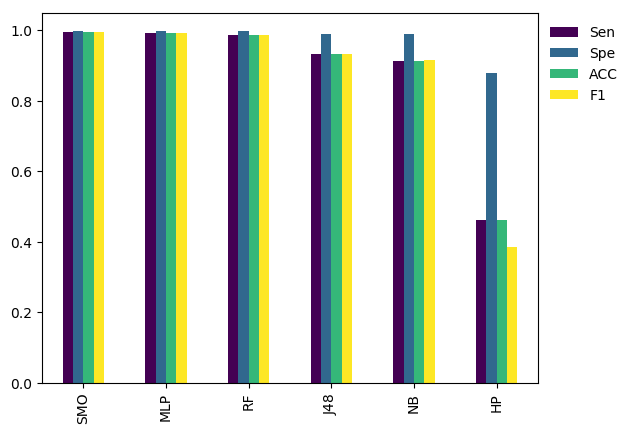

\begin{table}[ht]
\centering
    \begin{tabular}{lrrrr}
\toprule
\multicolumn{1}{c}{Scheme} & \multicolumn{1}{c}{Sen} & \multicolumn{1}{c}{Spe} & \multicolumn{1}{c}{ACC} & \multicolumn{1}{c}{F1}\\
\midrule
   SMO & 0.996 & 0.999 & 0.996 & 0.996 \\
   MLP & 0.994 & 0.999 & 0.994 & 0.994 \\
    RF & 0.988 & 0.997 & 0.988 & 0.988 \\
   J48 & 0.934 & 0.990 & 0.934 & 0.934 \\
    NB & 0.914 & 0.991 & 0.914 & 0.916 \\
    HP & 0.463 & 0.878 & 0.463 & 0.386 \\
\bottomrule
\end{tabular}
 \caption{\label{tab:training}10-fold cross-validation results. The results are ordered by $F1$ in descending order.
  The cells in bold represent the best value per column.}
\end{table}



In [15]:
df = pd.read_csv(path.join(results_path,'CV.csv'),index_col=0)
df.plot(kind='bar',colormap='viridis')
legend = plt.legend(loc='best',bbox_to_anchor=(1,1))
legend.draw_frame(False) 
plt.savefig(path.join(results_path,'CV.'+img_format),dpi=300,bbox_extra_artists=(legend,),bbox_inches='tight')
plt.show()

df = df.reset_index().rename(columns={'index':'Scheme'})
label = 'tab:training'
caption = '''10-fold cross-validation results. The results are ordered by $F1$ in descending order.
  The cells in bold represent the best value per column.'''
print(latex_table(df,label,caption))

# TEST

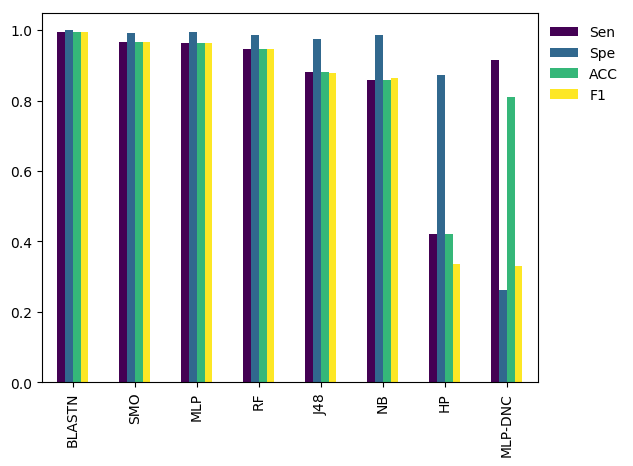

\begin{table}[ht]
\centering
    \begin{tabular}{lrrrr}
\toprule
\multicolumn{1}{c}{Scheme} & \multicolumn{1}{c}{Sen} & \multicolumn{1}{c}{Spe} & \multicolumn{1}{c}{ACC} & \multicolumn{1}{c}{F1}\\
\midrule
  BLASTN & 0.995 & 0.999 & 0.995 & 0.995 \\
     SMO & 0.966 & 0.993 & 0.966 & 0.966 \\
     MLP & 0.963 & 0.993 & 0.963 & 0.963 \\
      RF & 0.947 & 0.985 & 0.947 & 0.946 \\
     J48 & 0.881 & 0.976 & 0.881 & 0.879 \\
      NB & 0.858 & 0.987 & 0.858 & 0.863 \\
      HP & 0.422 & 0.872 & 0.422 & 0.337 \\
 MLP-DNC & 0.914 & 0.261 & 0.810 & 0.331 \\
\bottomrule
\end{tabular}
 \caption{\label{tab:test}Classifiers performance on the independent dataset. 
The results are ordered by $F1$ in descending order.
  The cells in bold represent the best value per column.}
\end{table}



In [16]:
#df = pd.read_csv(path.join(results_path,'TEST.csv'),index_col=0).drop(['BLASTN'])
df = pd.read_csv(path.join(results_path,'TEST.csv'),index_col=0)
df.plot(kind='bar',colormap='viridis')
legend = plt.legend(loc='best',bbox_to_anchor=(1,1))
legend.draw_frame(False) 
plt.savefig(path.join(results_path,'TEST.'+img_format),dpi=300,bbox_extra_artists=(legend,),bbox_inches='tight')
plt.show()

df = df.reset_index().rename(columns={'index':'Scheme'})
label = 'tab:test'
caption = '''Classifiers performance on the independent dataset. 
The results are ordered by $F1$ in descending order.
  The cells in bold represent the best value per column.'''
print(latex_table(df,label,caption))

## TEST SMO-HEXCFS

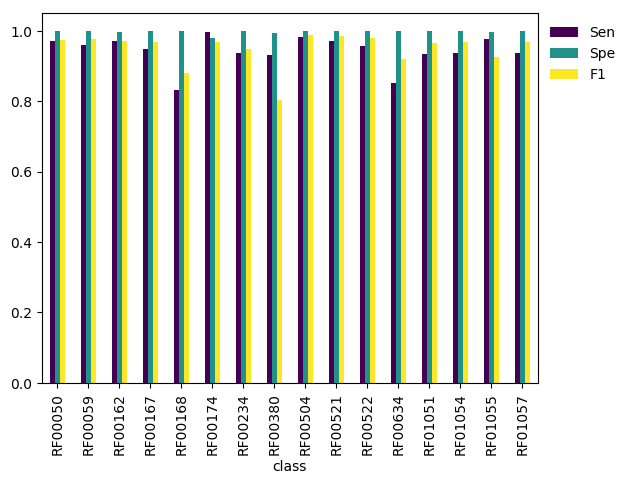

\begin{table}[ht]
\centering
    \begin{tabular}{lrrr}
\toprule
\multicolumn{1}{c}{class} & \multicolumn{1}{c}{Sen} & \multicolumn{1}{c}{Spe} & \multicolumn{1}{c}{F1}\\
\midrule
 RF00050 & 0.971 & 0.998 & 0.974 \\
 RF00059 & 0.961 & 0.998 & 0.976 \\
 RF00162 & 0.972 & 0.997 & 0.971 \\
 RF00167 & 0.949 & 1.000 & 0.968 \\
 RF00168 & 0.831 & 0.998 & 0.880 \\
 RF00174 & 0.996 & 0.978 & 0.968 \\
 RF00234 & 0.936 & 0.999 & 0.949 \\
 RF00380 & 0.931 & 0.995 & 0.802 \\
 RF00504 & 0.984 & 0.998 & 0.986 \\
 RF00521 & 0.970 & 1.000 & 0.985 \\
 RF00522 & 0.957 & 1.000 & 0.978 \\
 RF00634 & 0.851 & 1.000 & 0.919 \\
 RF01051 & 0.934 & 1.000 & 0.965 \\
 RF01054 & 0.938 & 1.000 & 0.968 \\
 RF01055 & 0.975 & 0.997 & 0.926 \\
 RF01057 & 0.938 & 1.000 & 0.968 \\
\bottomrule
\end{tabular}
 \caption{\label{tab:test-smo}SMO-HEXCFS performance by class on the test dataset.}
\end{table}

\begin{figure}[ht]
\centering
\includegraphics[width=\textwidth]{"figure_1_testsmo"}
\caption{Confusion matrix for SMO-HEXC

In [11]:
df = pd.read_csv(path.join(results_parsed_path,'HEXCFS_TEST-SMO-byclass.csv'),index_col=0)
df = df[['Sen','Spe','F1']]
df.plot(kind='bar',colormap='viridis')
legend = plt.legend(loc='best',bbox_to_anchor=(1,1))
legend.draw_frame(False) 
plt.savefig(path.join(results_path,'TEST-SMO-HEXCFS.'+img_format),dpi=300,bbox_extra_artists=(legend,),bbox_inches='tight')
plt.show()

df = df.reset_index().rename(columns={'index':'Scheme'})
label = 'tab:test-smo'
caption = '''SMO-HEXCFS performance by class on the test dataset.'''
print(latex_table(df,label,caption))

shutil.copy(path.join(results_parsed_path,'HEXCFS_TEST-SMO-confusion.'+img_format),
           path.join(manuscript_path,'figure_1_testsmo.'+img_format))
label = 'fig:testsmo'
caption = '''Confusion matrix for SMO-HEXCFS on the test set.
The color intensities represent the scaling of cell values with respect to the number of sequences per family. '''
print(latex_img('figure_1_testsmo',label,caption))

# TEST_HARD

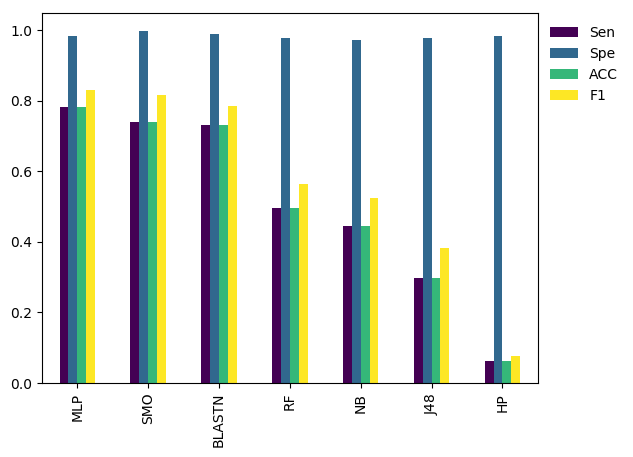

\begin{table}[ht]
\centering
    \begin{tabular}{lrrrr}
\toprule
\multicolumn{1}{c}{Scheme} & \multicolumn{1}{c}{Sen} & \multicolumn{1}{c}{Spe} & \multicolumn{1}{c}{ACC} & \multicolumn{1}{c}{F1}\\
\midrule
    MLP & 0.783 & 0.982 & 0.783 & 0.829 \\
    SMO & 0.739 & 0.998 & 0.739 & 0.815 \\
 BLASTN & 0.730 & 0.990 & 0.730 & 0.784 \\
     RF & 0.496 & 0.978 & 0.496 & 0.563 \\
     NB & 0.443 & 0.971 & 0.443 & 0.525 \\
    J48 & 0.296 & 0.978 & 0.296 & 0.381 \\
     HP & 0.061 & 0.984 & 0.061 & 0.077 \\
\bottomrule
\end{tabular}
 \caption{\label{tab:test-hard}Classifiers performance on test sequences with $E$-value$\geq 1.3E-2$.
The results are ordered by $F1$ in descending order.
  The cells in bold represent the best value per column.}
\end{table}



In [29]:
df = pd.read_csv(path.join(results_path,'TEST_HARD.csv'),index_col=0)
df.plot(kind='bar',colormap='viridis')
legend = plt.legend(loc='best',bbox_to_anchor=(1,1))
legend.draw_frame(False) 
plt.savefig(path.join(results_path,'TEST_HARD.'+img_format),dpi=300,bbox_extra_artists=(legend,),bbox_inches='tight')
plt.show()

df = df.reset_index().rename(columns={'index':'Scheme'})
#print(df)
label = 'tab:test-hard'
caption = '''Classifiers performance on test sequences with $E$-value$\geq 1.3E-2$.
The results are ordered by $F1$ in descending order.
  The cells in bold represent the best value per column.'''
print(latex_table(df,label,caption))

## TEST HARD MLP vs BLASTN

In [12]:
df1 = pd.read_csv(path.join(results_parsed_path,'HEXCFS_TEST_HARD-BLASTN-byclass.csv'),index_col=0)
df1 = df1[['support','Sen','Spe','F1']]
df2 = pd.read_csv(path.join(results_parsed_path,'HEXCFS_TEST_HARD-MultilayerPerceptron-byclass.csv'),index_col=0)
df2 = df2[['Sen','Spe','F1']]
df = df1.join(df2,how='inner', lsuffix='_blast', rsuffix='_mlp')
df = df[df['support']>0]
df = df[['support','Sen_blast','Sen_mlp','Spe_blast','Spe_mlp','F1_blast','F1_mlp']]

df = df.reset_index()
label = 'tab:test-hard-comp'
caption = '''Comparison of performance by class of MLP-HEXCFS and BLAST on hits with $E$-value$\geq$1.3E-2.'''
print(latex_table(df,label,caption))

shutil.copy(path.join(results_parsed_path,'HEXCFS_TEST_HARD-BLASTN-confusion.'+img_format),
           path.join(manuscript_path,'figure_2_testhardblast.'+img_format))
shutil.copy(path.join(results_parsed_path,'HEXCFS_TEST_HARD-MultilayerPerceptron-confusion.'+img_format),
           path.join(manuscript_path,'figure_3_testhardmlp.'+img_format))
label = 'fig:testhard-confusion'
caption = '''Confusion matrices for BLAST and MLP-HEXCFS on the sequences with $E$-value$\geq 1.3E-2$. 
A) BLASTN. B) MLP-HEXCFS. 
The color intensities represent the scaling of cell values with respect to the number of sequences per family. '''
print(latex_img('figure_2_testhardblast',label,caption))

\begin{table}[ht]
\centering
    \begin{tabular}{lrrrrrrr}
\toprule
\multicolumn{1}{c}{class} & \multicolumn{1}{c}{support} & \multicolumn{1}{c}{Sen\_blast} & \multicolumn{1}{c}{Sen\_mlp} & \multicolumn{1}{c}{Spe\_blast} & \multicolumn{1}{c}{Spe\_mlp} & \multicolumn{1}{c}{F1\_blast} & \multicolumn{1}{c}{F1\_mlp}\\
\midrule
 RF00059 &        1 &      1.000 &    1.000 &      0.939 &    1.000 &     0.222 &   1.000 \\
 RF00162 &        3 &      1.000 &    1.000 &      0.973 &    0.920 &     0.667 &   0.400 \\
 RF00167 &        7 &      0.857 &    0.857 &      1.000 &    0.991 &     0.923 &   0.857 \\
 RF00168 &       52 &      0.673 &    0.673 &      1.000 &    0.968 &     0.805 &   0.787 \\
 RF00174 &        2 &      1.000 &    1.000 &      0.920 &    0.956 &     0.308 &   0.444 \\
 RF00504 &       19 &      0.789 &    0.842 &      0.969 &    1.000 &     0.811 &   0.914 \\
 RF00522 &        4 &      0.500 &    1.000 &      1.000 &    1.000 &     0.667 &   1.000 \\
 RF00634 &        1 &   

# Imagenes Examen predoctoral

In [5]:
reporte = r'/home/hugo/Dropbox/DOCTORADO CICESE/000 TESIS/Reportes/2017-08-27 EXAMEN PREDOCTORAL/img'

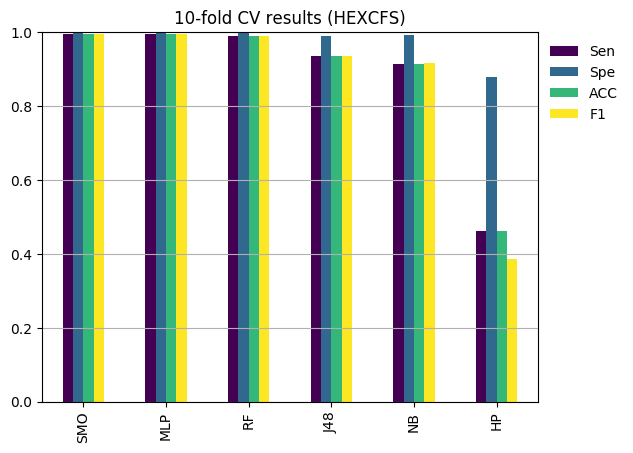

In [12]:
plt.close('all')
#CV
df = pd.read_csv(path.join(results_path,'CV.csv'),index_col=0)
df.plot(kind='bar',colormap='viridis')
legend = plt.legend(loc='best',bbox_to_anchor=(1,1))
legend.draw_frame(False) 
plt.title('10-fold CV results (HEXCFS)')

ax = plt.gca()
ax.set_ylim([0,1])
ax.yaxis.grid(True)
plt.savefig(path.join(reporte,'CV.'+img_format),dpi=300,bbox_extra_artists=(legend,),bbox_inches='tight')
plt.show()

              Sen       Spe       ACC        F1
BLASTN   0.995216  0.999023  0.995216  0.995152
SMO      0.965741  0.992911  0.965741  0.965951
MLP      0.963272  0.993350  0.963272  0.963432
RF       0.946759  0.985118  0.946759  0.945528
J48      0.880710  0.975931  0.880710  0.879175
NB       0.858025  0.986791  0.858025  0.863457
HP       0.421914  0.871635  0.421914  0.337118
MLP-DNC  0.914200  0.260900  0.810000  0.330500


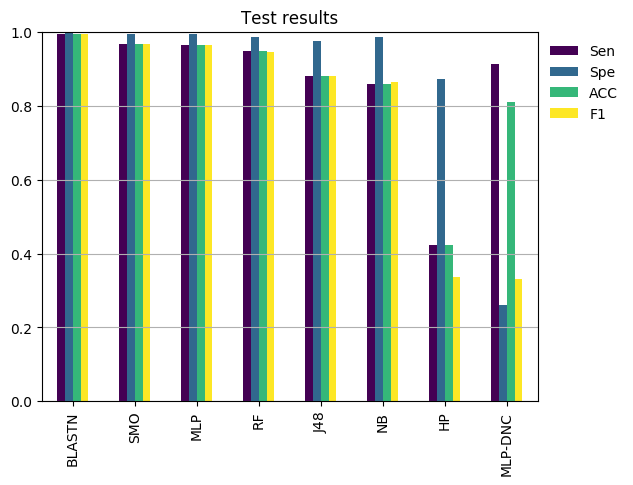

In [14]:
#TEST
df = pd.read_csv(path.join(results_path,'TEST.csv'),index_col=0)
df.plot(kind='bar',colormap='viridis')
legend = plt.legend(loc='best',bbox_to_anchor=(1,1))
legend.draw_frame(False) 
plt.title('Test results')
print(df)
ax = plt.gca()
ax.set_ylim([0,1])
ax.yaxis.grid(True)
plt.savefig(path.join(reporte,'TEST.'+img_format),dpi=300,bbox_extra_artists=(legend,),bbox_inches='tight')
plt.show()